# Image Matching Overview

In this module we will experiment with two domain of computational image analysis:  1) Comparison and Classification.  Matching describes the domain of effort where we are primarily concerned with computationally determining the degree to which any two images are the same.  For example, we may have a copy of a woodblock print that have found in one collection and want to know if other copies of the same print exist in other collections. 

The Classification domain is primarily focused on the degree to which images are similar to each other.  For example, we want to train a computer to search through large image catalogues and automatically separate all photographs of paintings from photographs of digital prints.  The OCR processes with which you have already worked are a good example of a classification problems.  The letter “D” appears in many fonts and sizes, many of which differ significantly, but as humans we still recognize them as belong to category (or class) of “D.”

The drive the to deploy computational methods in both domains is driving largely by the problem of scale and the cognitive difficulty that we, as human, encounter when trying to work with very large image collections—a problem that has amplified in this era of mass digitization.  But here, as elsewhere, we should not overlook the value that computers can bring to our work as intelligent provocateurs.  When we deploy computational methods, we frequently get seemingly bizarre and incorrect results.  However, we should not be so quick dismiss results that we fail to understand.  

Computers are, if nothing else, thorough and consistent, and the results that they produce are not arbitrary.  As such, we should seriously consider and work, when possible, to understand why they draw the conclusions they do, even when they seem nonsensical, as doing so often leads to new insights about the bias that we bring to our own research questions.


# Interpretability

All machine learning process are of two primary types:   Interpretable and uninterpretable.  Interpretable models are a class of model that expose the processes behind and reasons why they produce the final results that they produce.  Interpretable models frequently do not perform as well as their non-interpretable counterparts; however, their interpretability offers significant value to humanities scholars, as the process of working to interpret process behind the results achieved is playing field of intellectual provocation and response through which we can advance our own understanding of the artifacts we study.

When an interpretable model presents an unexpected result, we can investigate why, and learn something in the process.  When an uninterpretable process returns an unexpected result, all we do is call it wrong and move on.  

In this module, we will focus on interpretable models—one each in each of the domains of comparison and classification.  This notebook provides ready to run code, so you will not be required to do any heavy lifting on the coding front.  Rather, you are encouraged to run each process multiple times on multiple sets of images in order to see how they perform.  In each case, as you work, try to determine why the computer is drawing the conclusion it is drawing, rather than simply assessing whether you believe the results are right or wrong.  When we convene as a group, we will discuss our insights while trying to understand how the computer thinks.

# Environment Setup

First we'll install all required packages and modules into the environment.

In [1]:
# install the scikit-learn package
!pip install scikit-learn

In [2]:
# install the scikit-image package
!pip install scikit-image

Now we import the packages we need into the environement.

In [3]:
# import the openCV python package
# https://pypi.org/project/opencv-python/
# https://opencv.org/
import cv2

# import the numpy package
# https://numpy.org/
import numpy as np

# import scipy package and modules
# https://www.scipy.org/
import scipy
from scipy.cluster.hierarchy import dendrogram

# import the networkx package
# https://networkx.org/
import networkx as nx

# import the matplotlib package and modules
# https://matplotlib.org/
import matplotlib
import matplotlib.pyplot as plt

# import the pystest package
# https://docs.pytest.org/en/6.2.x/
import pytest

# import the random package
# https://docs.python.org/3/library/random.html
import random

# import the scikit-learn package and module
# https://scikit-learn.org/stable/
import sklearn
from sklearn.cluster import AgglomerativeClustering

# import the os library
# https://docs.python.org/3/library/os.html
import os

Mount the Google Drive.

In [4]:
from google.colab import drive
drive.mount('/gdrive/')

Mounted at /gdrive/


Here we define an input file path in the s2_class_data repo which contains several hundred images of woodcut impressions from the English Broadside Ballad Archive collection as well as an output directory where we will save files.  These directories will be reference by both sections of the notebook.

In [5]:
in_path = "/gdrive/MyDrive/rbs_digital_approaches_2021/s2_data_class/ebba_woodblocks/"
out_path = "/gdrive/MyDrive/rbs_digital_approaches_2021/output/"

# Feature Identification and Extraction

In this section of the notebook we will explore basic image matching techniques.  Contrary to popular expectation, image mapping is rarely accomplished by comparing the shape(s) of object.  Shape matching (contour matching, to image specialists) is an extremely faulty process because slight changes in orientation (such as those produced by changes in the orientation, height, or lens type of the camera taking the image have impacts on the shapes of things as they appear in images, as we’ve already discussed in class. 

One method of image comparison that can work quite well with modern, color photography is color histogram analysis.  With this process, each pixel in an image is examined and assigned a numeric score based on the color present in the pixel.  This creates a matrix representation of the image of the same dimensions as the pixel dimensions of the image.  This matrix can be compared with other matrices for similarity as a means of finding a matching image.  

As noted, this approach works well on color images with high contrast and a lot of objects pictured in them.  But it does not work well on black and white images, which comprise a great deal of the body of digitally available historical materials.  They also fail on high resolution color images of historical printed materials because both the structure and color of the paper on which they were printed changes from copy to copy, which changes the color score of the pixels.

The preferred method of performing interpretable, computational image mapping is known as Bag of Features matcing. We’ll explain the approach *in situ* as we work through its application below.


First, we'll load two images to compare from the previously defined working diectory.  Please take a moment to use the Google Drive web interface to naviagate to the './data_class/ebba_woodblocks/ dirctory in yor google drive  amd look at the photos we'll be using.

In [6]:
# Load the first Image
img_file_name = "rox-2-564-565.jpg"
img_file = in_path + img_file_name
img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

In [7]:
# Load the second Image
img2_file_name = "rox-1-100-101.jpg"
img_file = in_path + img2_file_name
img2 = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

Note that in the code above, not only did we load the images, but we also converted them to greyschale.  This is because the color information in the photo has no impact on feature identification but does require significantly more computational power to pross.  Cost without benefit is never good, so we simply remove the color information.

Now that we've identified and loaded two images for comparison, we need to declare an instance of the ORB_create feature extraction class from the Python OpenCV package.  

The Bag of Features approach discards the idea that images depict discreet objects (a picture of a person and a car, for example) in favor of the idea that they are really just containers for collections of small, mathematically definable features, such as circles and angles.   

To perform Bag of Features matching, for each image in a collection the computer first decomposes (blurs and the intensifies contrast) the image and then locates any lines (contours and edges) that appear in it.  It then looks for any changes in direction in line segments that create measurable and calculable angles.  These locations in the image are called "keypoints."  It then records the location of each keypoint along with its mathematial defintion in matrix form.  The keypoint and its description, combined, are called a feature.  And the matrix that stores all the features found in an image is known as a Bag of Features.

[OpenCV](https://opencv.org/) is a long-running, opensource image recognition platform, written in C++ that can be invoked through a Python wrapper.  And ORB is one of many feature extraction algorithms that can be run in OpenCV.  The most widely used and highest functioning feature extraction algorithms are the SURF and SIFT algorithms.  Unfortunately, because both are patent protected, they are not allowed to be used in Google Collaborator.  As such, we have defaulted to the opensource ORB algorithm.


In [8]:
# create a feature extraction object
# that uses open-source ORB features.
orb = cv2.ORB_create()

When performing feature extraction, you must tell the algorithm how many "levels" of extraction to perform.  Levels can be thought of as passes, where after each single pass and before the next a blurring filter is applied to the image.  This has the effect of gradually eroding smaller features and expanding larger one.  Here, we set the value to 3.  You should play around with this number and run different extractions to see how it affects the resulting features and matching.

In [9]:
# determine the number of levels
orb.setNLevels(3)

New we call the "detectAndCompute" function to genrate keypoints and descriptors for both of our test images.

In [10]:
keypoints, descriptors = orb.detectAndCompute(img, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

In the code cells below, we draw the features found in the first of our test images onto the image itself and save it to the Google Drive in the “output” directory of our course home directory. After you run the cell, look at the image to get an idea of where the computer has located features. Then, try a few more images. And then try the same images with different tunings.

When features are drawn on an image, the size of the circle represents the size of the feature.  And the line that extends from center to circumference shows the direction the feature angle is facing.

In [13]:
# create the new image with kehpoints drawn on it
img_w_featues = cv2.drawKeypoints(img, keypoints, None, None, flags=4)

Now we'll look at the image to see the identified keypoints.

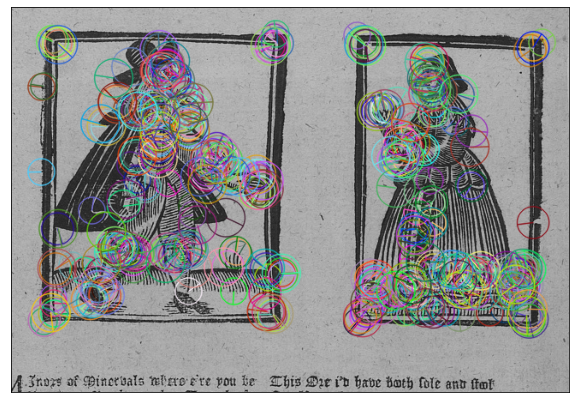

In [14]:
# Google Colab won't let us view images directly
# so we'll add them to a plot as a hack
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(img_w_featues, cmap=plt.cm.binary)
plt.show()

You can also save the keypoint image to your Google Drive.

In [ ]:
# write the keypoint image to Google Drive
out_img_path = out_path + "features_" + img_file_name
cv2.imwrite(out_img_path, img_w_featues )

# Direct Comparison Matching

Now that we've learned how to find, extract, and draw features on an image, it's time to do some image matching.  This is accomplished by finding the keypoints on any two image and then comparing the two sets of keypoints, the more keypoints that match, the more likely that the two images are the same.

Here, we need to say a few words about "sameness".  What exactly do we mean by "same."  Do we mean identical?  If so then two images would be the same if, and only if, they were exact copies of each other.  If one were cropped slightly smaller, or if it was of only half of the original sheet, it would not match with a perfect image of the whole sheet.  And what about skew? 

It turns out, there’s a fair amount of difference in things that as humans we generally consider to be the same.  The Bag of Features method solves many of the above problems because feature descriptions are both rotation and scale invariant, so neither the rotation nor the scale of images being examined affects the outcome.   

The sammple images that are pre-identifided below are designed to illustrate this point.  They are of wooblock impressions made on two diferent broadside ballads, with different surrounding maerial.  Once you run the match with these images, you should experiment with others.

The first step in the matching process is to create an instance of the needed matcher class.  

In [16]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

Now that we have a matcher ready, we send it the two sets of feature descriptions for our two images and let it look for matches.

In [17]:
# Match descriptors.
matches = bf.match(descriptors, descriptors2)

We'll now sort the matches based on their mathematic similarity.  This will allow us to look at the most significant one.

In [19]:
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

Now, we use the drawMatches function to draw the matches found between our two images on a new image.

In [20]:
# Draw first 50 matches.
image_w_matches = cv2.drawMatches(img, keypoints, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

And view the result.

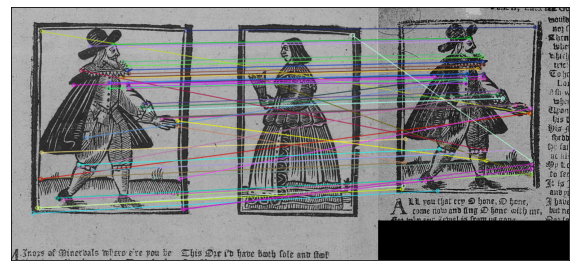

In [21]:
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_w_matches, cmap=plt.cm.binary)
    plt.show()

When you look at the matched image, you'll see that the majority of features in image 2, the smaller image with only one woodcut imporession, match to features found in the larger image.  Because the computer has found a high number of matching keypoints, it would determine that these images do match.  (In other words, match can be defind as a situation when the majority of keypoints in any image can be matched to any other image.)

We can also save the match image to disk for future viewing.

In [ ]:
out_img_path2 = out_path + "matches.jpg"
cv2.imwrite(out_img_path2, image_w_matches )

# Matching One to Many

In this section of the notebook we'll work on matching across a larger image library.  In the previous section, we used a brute-force matching technique that returned positive only if a direct match of features was found.  In this section, we’ll use Cosine Similarity to give us a similarity ranking for each image.  Cosine Similarity is a statiscal measure of how similar any two vectors or matrices are.  In our case, the bag of features for each image is represented as a matrix, so we can use Cosine Similiarity to get a measure of the similarity between bags of features.

To start, we'll need to get a directory listing/ filelist for our input directory.  

In [22]:
file_list = os.listdir(in_path) 

Now, we'll run our feature extraction on all images in the input directory.  To do this, we create an ORB object, setup some emtpy lists to hold features and descripters, then loop through each image in the directory and exract its features.  Note that running this cell could take several minutes.

In [23]:
# define a feature point extractor
orb = cv2.ORB_create()
orb.setNLevels(5)

# create and empty list to put features into
features_list = []
features_dict = dict()
image_names = []
image_descriptors = []
# loop through files and process
for next_file in file_list:
  # define the file path
  next_path = in_path + next_file
  # define a size for the descriptors vector
  needed_size = 50000

  # read in the file
  img = cv2.imread(next_path, cv2.IMREAD_GRAYSCALE)
  # calculate the keypoints
  #keypoints, descriptors = orb.detectAndCompute(img, None)

  # compute kepoints
  kps = orb.detect(img)

  # only keeping the largest 32 keypoints of each image
  kps = sorted(kps, key=lambda x: -x.response)[:32]

  # compute the descriptors vector
  kps, dsc = orb.compute(img, kps)
  # Flatten all of them in one big vector - our feature vector
  dsc = dsc.flatten()
  # Making descriptor of same size as Descriptor vector size is 64
  if dsc.size < needed_size:
    # if we have less the 32 descriptors then just adding zeros at the
    # end of our feature vector
     dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])

    # reshape the vector
    #dsc.reshape(1, -1)

  # make a list that associates the filename with the keypoints
  temp_list = [next_file, dsc]
  # add the single image data to the list of lists
  features_list.append(temp_list)
  features_dict.update({next_file: dsc})

  image_names.append(next_file)
  image_descriptors.append(dsc)

We'll designate the file we want to use as our seed here.  This image will be compared to all other images.  

In [24]:
# first set an image you want to test from
# the set of processed images
test_image = "20021-10.jpg"

# get the index for this image
test_index = image_names.index(test_image)

# get the descriptors for this image
test_descriptor = image_descriptors[test_index]

In [25]:
test_descriptor

array([120.,  40.,  50., ...,   0.,   0.,   0.])

Now we loop through every other image in the dataset and calculate the similarity score between the two images.  Note the commented out "np.dot" line in the for loop.  Dot Multiplication is another statistical method for assessing the similarity between vectors. If you have time, switch between the two siilarity calculations and see what effect it has on the outcome.

In [26]:
# create a list of comparision scores for this
# image against all images in set
sim_list = []
for i in range(len(image_descriptors)):
  #sim = np.dot(image_descriptors[test_index], image_descriptors[i])
  sim = scipy.spatial.distance.cosine(image_descriptors[test_index], image_descriptors[i])
  sim_list.append(sim)

Now that we've calculated all the similarity scores, we'll remove the original seed image from the dataset, otherwise we'd be comparing it to itself.

In [27]:
# remove test image from the data
img_names_temp = image_names
sim_list_temp = sim_list
del img_names_temp[test_index]
del sim_list_temp[test_index]


We also have to do some data munging.  We need to sort our results so that when we plot them they will be more readable.  The best way to do this is to take our list of image names and our list of similarity scores and join them as a dictionay, that way we can sort without loosing name/score associations.

In [29]:
# join our two lists as a dictionary
sim_dict = {img_names_temp[i]: sim_list_temp[i] for i in range(len(sim_list_temp))}
# now sort the dictionary
sim_dict = dict(sorted(sim_dict.items(), key=lambda x: x[1], reverse=True))

First, we'll plot the similarity scores for the entire dataset.

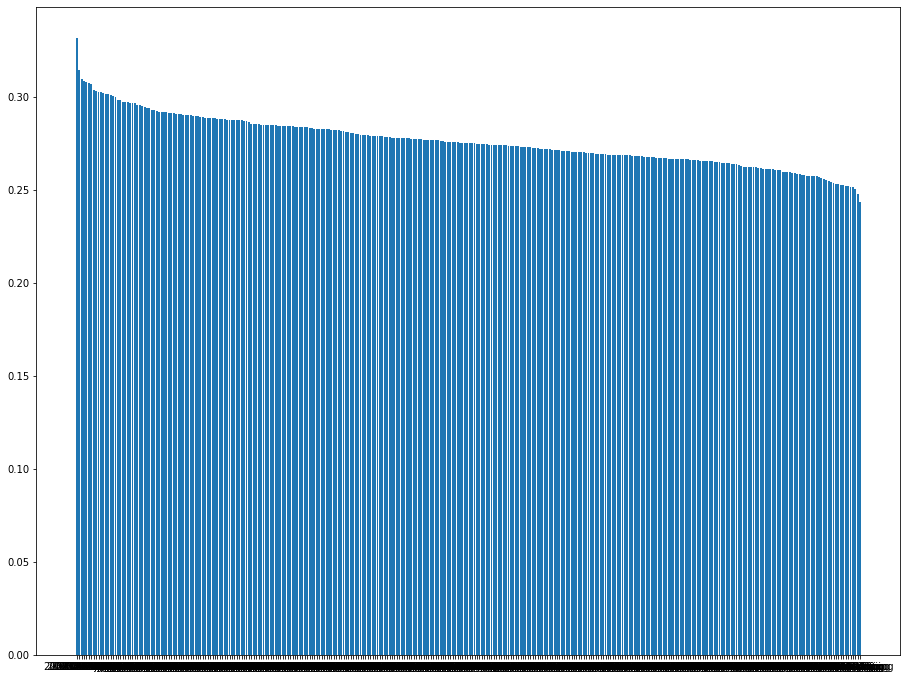

In [31]:
import matplotlib.pyplot as plt
# set the size of the plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_axes([0,0,1,1])
ax.bar(sim_dict.keys(), sim_dict.values())
plt.show()

The above visualization is useful for giving us an overall idea of shape of our data, but there are too many datapoints for the graph to be truly legible.  To solve this, let's subset the results and only look at the top most related images.

In [32]:
# subset first 20 items of list for plotting
sim_dict_subset = dict(list(sim_dict.items())[0: 10]) 

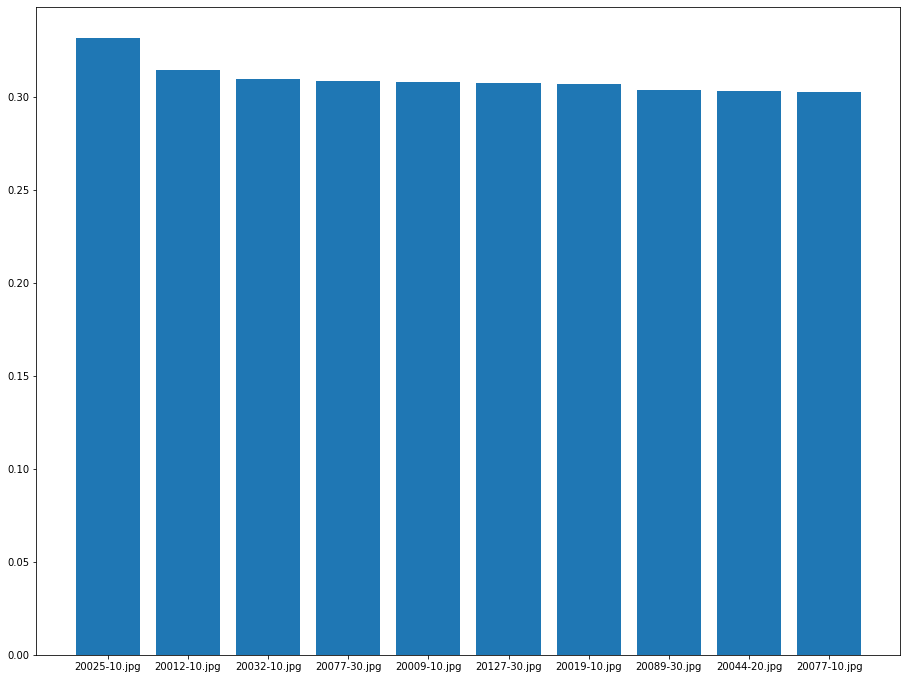

In [33]:
# draw the plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 9))
ax = fig.add_axes([0,0,1,1])
ax.bar(sim_dict_subset.keys(), sim_dict_subset.values())
plt.show()

# Clustering on Feature Similarity

In the above section, we saw how assess the similarity of a single image to a library of images.  In this section we'll examine clustering as an approach to examining the similarity of all images in a collection to each other based on their features.

In statistics, Cluster analysis, or clustering, is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data analysis, and a common technique for statistical data analysis, used in many fields, including pattern recognition, image analysis, information retrieval, bioinformatics, data compression, computer graphics and machine learning.

We've already built a collection of feature descriptors for each image in our collection.  To cluster these, we'll first model the similarity between the feature descriptors in our colleciton and then plot then plot a similarity network.

First, let's build a function for plotting a dendogram.  After we build our cluster model, we'll send the model to this function to create the actual dendogram.

In [34]:
# define a function that receives an hierarchical
# cluster model and a collection of keywords as arguments
def plot_dendrogram(model, **kwargs):

    # first, count the number of samples 
    # that appear under each node of the hierarchy
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # now that we have the node counts, we can create a "linkage"
    # matrix that stores the node relationships for each image
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # now we'll plot the linkage_matrix
    dendrogram(linkage_matrix, **kwargs)

Now we'll create an hierarchical model object and then fit the model to our image descriptors

In [35]:
# create the model. 
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# fit the model
model = model.fit(image_descriptors)

Now lets plot the entire similarity hierarchy

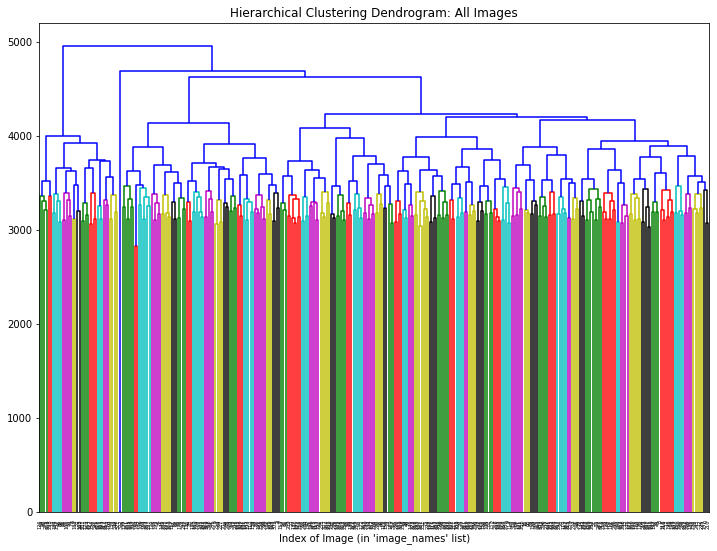

In [36]:
plt.figure(figsize=(12, 9))
plt.title('Hierarchical Clustering Dendrogram: All Images')
plot_dendrogram(model)
plt.xlabel("Index of Image (in 'image_names' list)")
plt.show()

As you can see, there are too many images in our model to visualize any discrete relationships between individual images.  The complete dendogram gives us a good sense of how similarity plays out across the entire collection, but you can't really tell which images are related to which other images.  

To remedy this, we'll next produce a truncated plot where we only plot details for three levels of the hierarchy.

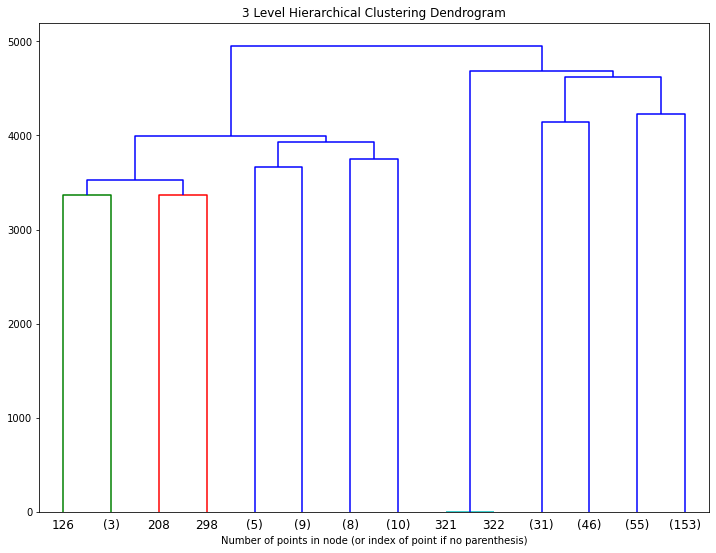

In [37]:
plt.figure(figsize=(12, 9))
plt.title('3 Level Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()